## Contents
-  [1.Importing Libraries](#1)
-  [2.Dataset Managament](#2)
    -  [2.1.Downloading , Extracting and Spliting Dataset](#2.1)
    -  [2.2.Pytorch Dataset](#2.2)
    -  [2.3.Pytorch DataLoaders](#2.3)
-  [3.Creating a CNN Model](#3)
-  [4.Training](#4)
-  [5.Plotting Graphs](#5)
    -  [5.1.Plotting Loss vs Epoch](#5.1)
    -  [5.2.Plotting Accuracy vs Epoch](#5.2)
-  [6.Loading and Testing](#6)

### 1.Importing Libraries <a class="anchor" id="1"></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import wget
import tarfile
import os
import torchvision.transforms as T

sns.set_style("darkgrid")

### 2.Dataset Managament <a class="anchor" id="2"></a>

#### 1.Downloading , Extracting and Spliting Dataset <a class="anchor" id="2.1"></a>

In [2]:

zip_file_url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
#check if the zipfile already exists

if "images.tar" not in os.listdir() :
    wget.download('http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar')
    
#check if the zip file is extracted

if len(os.listdir("data/"))== 0:

    # open file
    file = tarfile.open('images.tar')
  
    # extracting file
    file.extractall('data/')
    print("Extraction completed")
    file.close()
     
    # creating train , test and validation folders
    path = "data/"
    classes = os.listdir(path+'/images')
    os.mkdir("data/train")
    os.mkdir("data/test")
    os.mkdir("data/validation")
            
    for i in classes:
        os.mkdir('data/train/'+i)
        os.mkdir('data/test/'+i)
        os.mkdir('data/validation/'+i)
    
    # (class_n , images_name) storing all the image name/location
    images_path = []
    for i in classes:
        temp = []
        for j in os.listdir(path+'images/'+i+'/'):
            temp.append(j)
        images_path.append(temp)
    
    # splitting train , test and validation images for each classes
    
    train = 0.9
    test = 0.075
    validatiation = 0.025

    train_img_path = []
    test_img_path = []
    validation_img_path = []

    for i in images_path:
        n = len(i)
        train_n = int(train*n)
        test_n = int(test*n)
        validation_n = n - train_n - test_n
    
        train_img_path.append(i[:train_n])
        test_img_path.append(i[train_n:test_n+train_n])
        validation_img_path.append(i[train_n+test_n:])
    
    # Moving corresponding images to the train , test and validation folders

    for i,class_name in zip(train_img_path,classes):
        for j in i:
            os.rename(path+"Images/"+class_name+"/"+j, path+"train/"+class_name+"/"+j)
        
    for i,class_name in zip(test_img_path,classes):
        for j in i:
            os.rename(path+"Images/"+class_name+"/"+j, path+"test/"+class_name+"/"+j)
        
    for i,class_name in zip(validation_img_path,classes):
        for j in i:
            os.rename(path+"Images/"+class_name+"/"+j, path+"validation/"+class_name+"/"+j)
            

#### 2.Pytorch Dataset <a class="anchor" id="2.2"></a>

In [3]:
class Dataset(Dataset):
    def __init__(self , type = 'train' , transform = 'T.Resize((256,256))'):
        self.x = []
        self.y = []
        self.transform = transform
        self.n_classes = len(os.listdir('data/train/'))
        if type == 'train':
            path = 'data/train/'
            classes = os.listdir(path)
            for i in range(len(classes)):
                for j in os.listdir(path+classes[i]):
                    self.x.append(path+classes[i]+'/'+j)
                    self.y.append(i)

        if type == 'test':
            path = 'data/test/'
            classes = os.listdir(path)
            for i in range(len(classes)):
                for j in os.listdir(path+classes[i]):
                    self.x.append(path+classes[i]+'/'+j)
                    self.y.append(i)
                    
        if type == 'validation':
            path = 'data/validation/'
            classes = os.listdir(path)
            for i in range(len(classes)):
                for j in os.listdir(path+classes[i]):
                    self.x.append(path+classes[i]+'/'+j)
                    self.y.append(i)
                    
        self.len = len(self.x)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self,i):
        image = self.transform(Image.open(self.x[i]))
        x = torch.FloatTensor(np.asarray(image))[:,:,:3]
        return x,torch.LongTensor([self.y[i]])
    


#### 3.Pytorch DataLoaders <a class="anchor" id="2.3"></a>

In [4]:
batch_size = 16
classes = os.listdir('data/train/')
n_classes = len(classes)

train_transforms = T.Compose([T.Resize((512,512))
#                        T.RandomRotation(degrees=30),
#                        T.RandomHorizontalFlip(p=0.3),
])

test_transforms = T.Compose([T.Resize((512,512))])

train_dataset = Dataset('train',transform =train_transforms )
test_dataset = Dataset('test',transform =test_transforms )
validation_dataset = Dataset('validation',transform =test_transforms )

train_dataloader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True )
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)
validation_dataloader = DataLoader(validation_dataset, batch_size = batch_size)

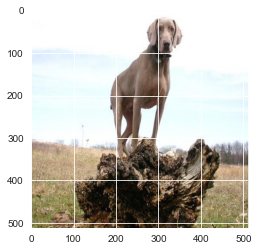

In [5]:
plt.imshow(next(iter(train_dataloader))[0][0].numpy()/255)
plt.show()

### 3.Creating a CNN Model <a class="anchor" id="3"></a>

In [6]:
class CNN_model(nn.Module):
    def __init__(self,batch_size,n_classes):
        super().__init__()
        self.batch_size = batch_size
        self.n_classes = n_classes
        
        self.conv1 = nn.Conv2d(3,32,3,2)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32,64,3,2)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64,64,3,2)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64,64,3)
        self.maxpool4 = nn.MaxPool2d(2, 2)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(256,256)
        self.fc2 = nn.Linear(256, out_features=120)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(self.maxpool1(x))
        
        x = F.relu(self.conv2(x))
        x = self.bn2(self.maxpool2(x))
        
        x = F.relu(self.conv3(x))
        x = self.bn3(self.maxpool3(x))
        
        x = F.relu(self.conv4(x))
        x = self.bn3(self.maxpool4(x))
        
        x = x.reshape((self.batch_size,256))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x
        
        


lr = 0.01
epoch = 10
train_dataset_size = train_dataset.__len__()
validation_dataset_size = validation_dataset.__len__()
train_n_minibatches = train_dataloader.__len__()
validation_n_minibatches = validation_dataloader.__len__()

device = 'cuda'
loss_history = [[],[]] #[[train], [validation]]
accuracy_history = [[],[]] #[[train], [validation]]

criterion = nn.CrossEntropyLoss()
model = CNN_model(batch_size,n_classes).to(device)    
optimizer = torch.optim.SGD(model.parameters(),lr = lr)

### 4.Training <a class="anchor" id="4"></a>

In [7]:
for e in range(epoch):
    for batch_idx , (x ,y) in enumerate(train_dataloader):
        if x.shape[0] !=16 or x.shape[3]!=3:
            continue
        optimizer.zero_grad()
        x , y = x.to(device) , y.to(device)
        y_pred = model(x.reshape((batch_size,3,512,512))).to(device)
        loss = criterion(y_pred,y.reshape(batch_size))
        loss.backward()
        optimizer.step()
        loss_history[0].append(float(loss.detach()))
        
        correct = 0
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = y.cpu().detach().numpy().tolist()
        for i in range(batch_size):
            n = 0
            n = y_pred[i].index(max(y_pred[i]))
            if n == y[i]:
                correct = correct + 1
        accuracy_history[0].append((correct/len(y))*100)
        
        if batch_idx % 100 == 0:
#             print(f'LOSS for EPOCH {e+1} BATCH {batch_idx}/{train_n_minibatches} TRAIN LOSS : {loss_history[0][-1]}',end = ' ')
#             print(f'TRAIN ACCURACY : {accuracy_history[0][-1]}',end = ' ')
            with torch.no_grad():
                for _batch_idx_ , (x ,y) in enumerate(validation_dataloader):
                    if x.shape[0] != 16 or x.shape[3]!=3:
                        continue
                    x , y = x.to(device) , y.to(device)
                    y_pred = model(x.reshape((batch_size,3,512,512))).to(device)
                    validation_loss = criterion(y_pred,y.reshape(batch_size))
                    loss_history[1].append(float(validation_loss.detach()))
                    
                    y_pred = y_pred.cpu().detach().numpy().tolist()
                    y = y.cpu().detach().numpy().tolist()      
                    for i in range(batch_size):
                        n = 0
                        n = y_pred[i].index(max(y_pred[i]))
                        if n == y[i][0]:
                            correct = correct + 1
                    accuracy_history[0].append((correct/len(y))*100)
                        
                    
#                 print(f'VALIDATION LOSS : {sum(loss_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}',end = ' ')
#                 print(f'VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}')
    
    torch.save(model.state_dict(),'saved_model/custom_CNN')
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    print(f'Loss for EPOCH {e+1}  TRAIN LOSS : {sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}',end = ' ')
    print(f'TRAIN ACCURACY : {sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}')
    n_validation_losses = int(train_n_minibatches/100)*validation_n_minibatches
    print(f'VALIDATION LOSS for EPOCH {e+1} : {sum(loss_history[1][-1:-1*n_validation_losses-1:-1])/n_validation_losses}',end = ' ')
    print(f'VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-1*n_validation_losses-1:-1])/n_validation_losses}')
    print('---------------------------------------------------------------------------------------------')

---------------------------------------EPOCH 1-------------------------------------------
Loss for EPOCH 1  TRAIN LOSS : 4.783353972331786 TRAIN ACCURACY : 4.377705627705628
VALIDATION LOSS for EPOCH 1 : 4.7875727707689455 VALIDATION ACCURACY : 0.0
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 2-------------------------------------------
Loss for EPOCH 2  TRAIN LOSS : 4.787449605950029 TRAIN ACCURACY : 5.162337662337662
VALIDATION LOSS for EPOCH 2 : 4.78757325519215 VALIDATION ACCURACY : 0.0
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 3-------------------------------------------
Loss for EPOCH 3  TRAIN LOSS : 4.787378839600138 TRAIN ACCURACY : 5.687229437229437
VALIDATION LOSS for EPOCH 3 : 4.787457333911549 VALIDATION ACCURACY : 0.0
--------------------------------------------------------------------

### 5.Plotting Graphs<a class="anchor" id="5"></a>

#### 1.Plotting Loss vs Epoch<a class="anchor" id="5.1"></a>

c:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


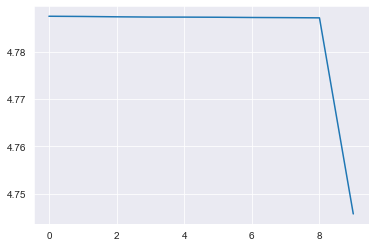

In [13]:
loss_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in loss_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    loss_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in loss_history[1][i*n_validation_losses:(i+1)*n_validation_losses]:
        temp = temp + j
    loss_per_epoch[1].append(temp/n_validation_losses)    

sns.lineplot(range(len(loss_per_epoch[0])),loss_per_epoch[0])
# sns.lineplot(range(len(loss_per_epoch[1])),loss_per_epoch[1])
plt.show()

#### 2.Plotting Accuracy vs Epoch<a class="anchor" id="5.2"></a>

c:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


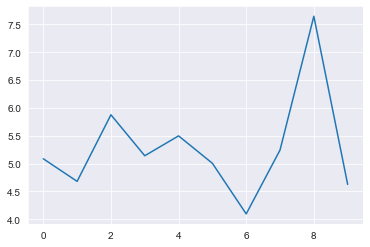

In [14]:
accuracy_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in accuracy_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    accuracy_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in accuracy_history[1][i*n_validation_losses:(i+1)*n_validation_losses]:
        temp = temp + j
    accuracy_per_epoch[1].append(temp/n_validation_losses)    

sns.lineplot(range(len(accuracy_per_epoch[0])),accuracy_per_epoch[0])
# sns.lineplot(range(len(accuracy_per_epoch[1])),accuracy_per_epoch[1])
plt.show()

### 6.Loading and Testing<a class="anchor" id="6"></a>

In [10]:
model = CNN_model(batch_size,n_classes)
model.load_state_dict(torch.load('saved_model/custom_CNN', map_location='cpu'))
model.to('cuda')


CNN_model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, o

In [12]:
test_loss_history = []
test_accuracy_history = []
model = model.to('cpu')
model.eval()

for _batch_idx_ , (x ,y) in enumerate(test_dataloader):
    if x.shape[0] !=16:
        continue
    y_pred = model(x.reshape((batch_size,3,512,512)))
    test_loss = criterion(y_pred,y.reshape(x.shape[0]))
    test_loss_history.append(float(test_loss.detach()))
    correct = 0
    y_pred = y_pred.detach().numpy().tolist()
    y = y.detach().numpy().tolist()      
    for i in range(x.shape[0]):
        n = 0
        n = y_pred[i].index(max(y_pred[i]))
        if n == y[i][0]:
            correct = correct + 1
    test_accuracy_history.append((correct/len(y))*100)
                        
print(f'LOSS : {sum(test_loss_history)/len(test_loss_history)}  ACCURACY : {sum(test_accuracy_history)/len(test_accuracy_history)}')                    

LOSS : 4.787404215854147  ACCURACY : 1.1548913043478262
